In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("dnm_bt.csv")

# Veri setindeki ilk üç satır 
df.head(3)

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary
0,09/17/1908,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,07/12/1912,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
2,08/06/1913,NaN,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0.0,The first fatal airplane accident in Canada oc...


In [3]:

df = df.head(10000)

In [4]:
# LDA modelinde sadece "text" sütununu kullanmamız yeterli olacaktır.
haber_veriseti = df[["Summary"]]
haber_veriseti=haber_veriseti.astype(str)
haber_veriseti.head(3)

,Summary
0,"During a demonstration flight, a U.S. Army fly..."
1,First U.S. dirigible Akron exploded just offsh...
2,The first fatal airplane accident in Canada oc...


In [5]:

import re
import string
import nltk
from nltk.corpus import stopwords

nok_isaretleri_kümesi = string.punctuation
# nltk kütüphanesinin etkisiz kelimeler kümesini kullanalım 
etkisiz_kelimeler_kümesi = stopwords.words('english') 
# stopwords kümesine biz de istediğimiz kelimeleri ekleyebiliriz
# Örnek:
etkisiz_kelimeler_kümesi.extend(["bir","kadar","sonra"])

def veri_temizleme(metin):
    metin = metin.lower()
    metin = metin.replace("\\n"," ")
    metin = re.sub("’(\w+)", "", metin) 
    metin = re.sub("'(\w+)", "", metin) 
    metin = re.sub("[“,‘,’,”]", "", metin) 
    metin = re.sub("[0-9]+", "", metin)
    metin = "".join(list(map(lambda x:x if x not in nok_isaretleri_kümesi else " ", metin)))
    metin = " ".join([i for i in metin.split() if i not in etkisiz_kelimeler_kümesi])
    metin = " ".join([i for i in metin.split() if len(i) > 1])

    return metin

In [6]:
haber_veriseti["temizlenen_metin"] = haber_veriseti["Summary"].apply(lambda x:veri_temizleme(x))

In [7]:
haber_veriseti.iloc[5].Summary

'Crashed into trees while attempting to land after being shot down by British and French aircraft.'

In [8]:
haber_veriseti.iloc[5].temizlenen_metin

'crashed trees attempting land shot british french aircraft'

In [9]:
haber_veriseti["temizlenen_metin_token"] = haber_veriseti["temizlenen_metin"].apply(lambda x: x.split())

In [10]:

haber_veriseti.head(10)

,Summary,temizlenen_metin,temizlenen_metin_token
0,"During a demonstration flight, a U.S. Army fly...",demonstration flight army flyer flown orville ...,"[demonstration, flight, army, flyer, flown, or..."
1,First U.S. dirigible Akron exploded just offsh...,first dirigible akron exploded offshore altitu...,"[first, dirigible, akron, exploded, offshore, ..."
2,The first fatal airplane accident in Canada oc...,first fatal airplane accident canada occurred ...,"[first, fatal, airplane, accident, canada, occ..."
3,The airship flew into a thunderstorm and encou...,airship flew thunderstorm encountered severe d...,"[airship, flew, thunderstorm, encountered, sev..."
4,Hydrogen gas which was being vented was sucked...,hydrogen gas vented sucked forward engine igni...,"[hydrogen, gas, vented, sucked, forward, engin..."
5,Crashed into trees while attempting to land af...,crashed trees attempting land shot british fre...,"[crashed, trees, attempting, land, shot, briti..."
6,"Exploded and burned near Neuwerk Island, when...",exploded burned near neuwerk island hydrogen g...,"[exploded, burned, near, neuwerk, island, hydr..."
7,"Crashed near the Black Sea, cause unknown.",crashed near black sea cause unknown,"[crashed, near, black, sea, cause, unknown]"
8,Shot down by British aircraft crashing in flames.,shot british aircraft crashing flames,"[shot, british, aircraft, crashing, flames]"
9,Shot down in flames by the British 39th Home D...,shot flames british th home defence squadron,"[shot, flames, british, th, home, defence, squ..."


In [11]:
import gensim
import pyLDAvis.gensim_models


In [12]:
tokenlastirilmis_metinler = haber_veriseti["temizlenen_metin_token"]
kelime_listesi = gensim.corpora.Dictionary(tokenlastirilmis_metinler)

kelime_listesi.filter_extremes(no_below=1, no_above=0.7)

d:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
# Terimlerin Vektörleştirilmesi -- Doküman-Terim Matrisinin Oluşturulması
dokuman_terim_matrisi = [kelime_listesi.doc2bow(terim) for terim in tokenlastirilmis_metinler]

d:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
# LDA Model
lda_model = gensim.models.ldamodel.LdaModel(corpus = dokuman_terim_matrisi,
                                           id2word = kelime_listesi,
                                           num_topics = 15, 
                                           passes = 10)

d:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
konular = lda_model.print_topics(num_words=7) 

for konu in konular:
    print(konu)

(0, '0.056*"conditions" + 0.055*"flight" + 0.054*"pilot" + 0.044*"weather" + 0.030*"vfr" + 0.020*"adverse" + 0.020*"continued"')
(1, '0.031*"pilot" + 0.022*"impacted" + 0.021*"disorientation" + 0.018*"killed" + 0.018*"spatial" + 0.018*"two" + 0.017*"air"')
(2, '0.087*"nan" + 0.018*"cessna" + 0.012*"plane" + 0.012*"management" + 0.011*"experience" + 0.011*"killed" + 0.009*"pilots"')
(3, '0.057*"runway" + 0.053*"landing" + 0.044*"plane" + 0.030*"aircraft" + 0.027*"crashed" + 0.017*"around" + 0.016*"attempting"')
(4, '0.040*"aircraft" + 0.032*"fire" + 0.030*"wing" + 0.024*"flight" + 0.021*"left" + 0.020*"caused" + 0.020*"control"')
(5, '0.073*"engine" + 0.029*"fuel" + 0.028*"failure" + 0.027*"power" + 0.026*"aircraft" + 0.017*"engines" + 0.017*"crashed"')
(6, '0.040*"failure" + 0.036*"pilot" + 0.035*"flight" + 0.026*"aircraft" + 0.025*"altitude" + 0.025*"crew" + 0.020*"accident"')
(7, '0.052*"helicopter" + 0.042*"crashed" + 0.031*"turbulence" + 0.030*"aircraft" + 0.025*"sea" + 0.021*"seve

d:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
pyLDAvis.enable_notebook()
gorsel = pyLDAvis.gensim_models.prepare(lda_model,corpus=dokuman_terim_matrisi,dictionary=kelime_listesi, mds='mmds')
pyLDAvis.display(gorsel)

d:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Tutarlılık (Coherence) Skoru ile En iyi Konu Sayısı Seçimi 

In [18]:
from gensim.models import CoherenceModel

konu_sayisi_aralik_listesi = range(9,30,3)

d:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
tutarlilik_skorlar_listesi = list()
konu_sayisi_listesi = list()

for konu_sayisi in konu_sayisi_aralik_listesi:
    lda_model = gensim.models.ldamodel.LdaModel(corpus = dokuman_terim_matrisi,
                                               id2word = kelime_listesi,
                                               num_topics = konu_sayisi, 
                                               passes = 10)
    
    tutarlilik_model_lda = CoherenceModel(model=lda_model, texts=tokenlastirilmis_metinler, 
                                          dictionary=kelime_listesi, coherence='c_v')
    gecici_tutarlilik_skoru_lda = tutarlilik_model_lda.get_coherence()
    tutarlilik_skorlar_listesi.append(gecici_tutarlilik_skoru_lda)
    konu_sayisi_listesi.append(konu_sayisi)

d:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


d:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


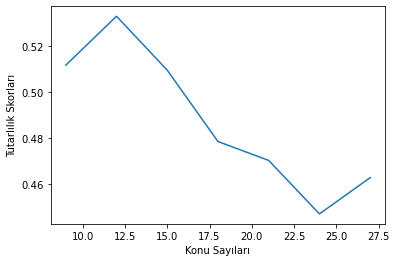

In [20]:
import matplotlib.pyplot as plt

plt.plot(konu_sayisi_listesi, tutarlilik_skorlar_listesi, "-"),
plt.xlabel("Konu Sayıları")
plt.ylabel("Tutarlılık Skorları")

plt.show()

In [38]:

lda_model = gensim.models.ldamodel.LdaModel(corpus = dokuman_terim_matrisi,
                                           id2word = kelime_listesi,
                                           num_topics = 10, 
                                           passes = 20)

d:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
konular = lda_model.print_topics(num_words=7) 
konular = sorted(konular, key = lambda x: x[0]) 
for konu in konular:
    print(konu)

(0, '0.085*"crashed" + 0.038*"weather" + 0.032*"land" + 0.031*"plane" + 0.026*"conditions" + 0.026*"poor" + 0.025*"mountain"')
(1, '0.032*"failure" + 0.018*"flight" + 0.017*"airplane" + 0.017*"control" + 0.014*"accident" + 0.013*"contributing" + 0.013*"crew"')
(2, '0.023*"dc" + 0.016*"midair" + 0.015*"collision" + 0.011*"killed" + 0.010*"safely" + 0.010*"nearby" + 0.010*"piper"')
(3, '0.038*"pilot" + 0.032*"crashed" + 0.028*"flight" + 0.026*"route" + 0.023*"en" + 0.022*"terrain" + 0.020*"aircraft"')
(4, '0.102*"runway" + 0.039*"short" + 0.038*"landing" + 0.032*"go" + 0.030*"around" + 0.025*"crashed" + 0.021*"plane"')
(5, '0.126*"nan" + 0.086*"helicopter" + 0.027*"rotor" + 0.010*"main" + 0.009*"fracture" + 0.008*"blade" + 0.008*"separation"')
(6, '0.028*"plane" + 0.025*"aircraft" + 0.016*"flight" + 0.014*"crashed" + 0.011*"airport" + 0.011*"fuel" + 0.010*"crew"')
(7, '0.048*"crashed" + 0.044*"engine" + 0.034*"aircraft" + 0.028*"failure" + 0.028*"plane" + 0.024*"takeoff" + 0.015*"pilot"'

d:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
pyLDAvis.enable_notebook()
gorsel = pyLDAvis.gensim_models.prepare(lda_model, dokuman_terim_matrisi, kelime_listesi, mds='mmds')
pyLDAvis.display(gorsel)

d:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [47]:
all_topics = {}
lambd = 0.6  # Adjust this accordingly
for i in range(1,22): #Adjust number of topics in final model
    topic = gorsel.topic_info[gorsel.topic_info\
            .Category == 'Topic'+str(i)]
    topic['relevance'] = topic['loglift']*(1-lambd)\
                         +topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance'\
            , ascending=False).Term[:10].values

d:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-47-b723aa576f0c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic['relevance'] = topic['loglift']*(1-lambd)\
